# Train Pixel Classifier

In [43]:
import os
import pickle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

import sys
sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_pixel_vectors
from scripts.viz_tools import stretch_histogram

np.random.seed(1)

In [2]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

In [3]:
def normalize(x):
    return (np.array(x)) / (3000)

def compute_ndvi(pixel_vectors):
    return (pixel_vectors[:,7] - pixel_vectors[:,3]) / (pixel_vectors[:,7] + pixel_vectors[:,3])

## Create a Training Dataset
Outputs will be: `x_train`, `y_train`, `x_test`, `y_test`, `x_holdout`, `y_holdout`. Holdout data is only positive

In [5]:
train_data_dir = '../data/training_data/pixel_vectors/'

with open(os.path.join(train_data_dir, "negative_pixel_vectors_toa_12_2019-01-01.pkl"), 'rb') as file:
    x_negative = np.array(pickle.load(file))


# Bootstrap data is an example for now of adding data to classifier
with open(os.path.join(train_data_dir, "bootstrap_data_toa.pkl"), 'rb') as file:
    x_negative_bootstrap = np.array(pickle.load(file))
    
x_negative = np.concatenate((x_negative, x_negative_bootstrap))

y_negative = np.zeros(len(x_negative))

with open(os.path.join(train_data_dir, "positive_pixel_vectors_toa_36_2018-01-01.pkl"), 'rb') as file:
    x_positive = np.array(pickle.load(file))

with open(os.path.join(train_data_dir, "positive_holdout_pixel_vectors_toa_3_2018-01-01.pkl"), 'rb') as file:
    x_holdout = np.array(pickle.load(file))

### Filter positive samples such that NDVI is within a range
This is useful since the positive patches can include surrounding vegetation

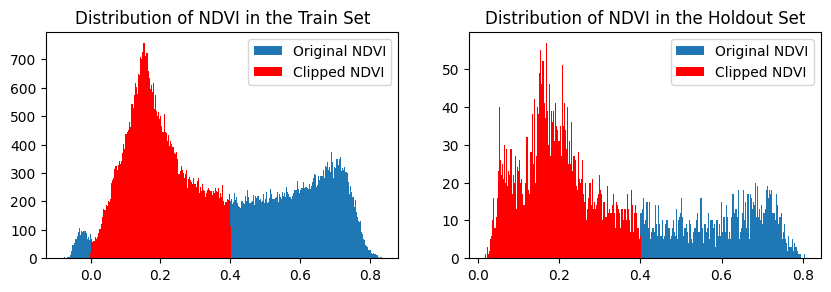

In [6]:
ndvi_train = compute_ndvi(x_positive)
ndvi_holdout = compute_ndvi(x_holdout)

lower_ndvi_bound = 0
upper_ndvi_bound = 0.4
index_train = np.logical_and(ndvi_train > lower_ndvi_bound, ndvi_train < upper_ndvi_bound)
index_holdout = np.logical_and(ndvi_holdout > lower_ndvi_bound, ndvi_holdout < upper_ndvi_bound)

x_positive = x_positive[index_train]
y_positive = np.ones(len(x_positive))
x_holdout = x_holdout[index_holdout]
y_holdout = np.ones(len(x_holdout))

plt.figure(figsize=(10,3), dpi=100, facecolor=(1,1,1))
plt.subplot(1,2,1)
edges, bins, patches = plt.hist(ndvi_train, bins=300, label='Original NDVI')
plt.hist(ndvi_train[index_train], bins=bins, color='r', label='Clipped NDVI')
plt.title('Distribution of NDVI in the Train Set')
plt.legend()

plt.subplot(1,2,2)
edges, bins, patches = plt.hist(ndvi_holdout, bins=300, label='Original NDVI')
plt.hist(ndvi_holdout[index_holdout], bins=bins, color='r', label='Clipped NDVI')
plt.title('Distribution of NDVI in the Holdout Set')
plt.legend()

plt.show()

### Create train test split
Also expand dimensions to account for batches

In [7]:
x = np.concatenate((x_positive, x_negative))
y = np.concatenate((y_positive, y_negative))

x, y = shuffle(x, y, random_state=42)
x = normalize(x)
x_holdout = normalize(x_holdout)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print("Num Train Samples:\t\t", len(x_train))
print("Num Test Samples:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_holdout = np.expand_dims(x_holdout, -1)

# Note: I am accustomed to assigning two classes for binary classification. 
# This habit comes from an issue in theano a long time ago, but I'm too superstitious to change it.
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_holdout = keras.utils.to_categorical(y_holdout, num_classes)

Num Train Samples:		 734460
Num Test Samples:		 183616
Percent Negative Train:	 95.1
Percent Negative Test:	 95.0


## Create and Train a Model

In [24]:
input_shape = np.shape(x_train[0])
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv1D(16, kernel_size=(3), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2)),
        layers.Conv1D(32, kernel_size=(3), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 10, 16)            64        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 32)             1568      
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

### Optional Class Weighting
Over experimental testing, I found that weighting classes seemed to degrade performance. This could use further investigation

In [ ]:
from sklearn.utils import class_weight
negative_weight, positive_weight = class_weight.compute_class_weight('balanced', 
                                                                     classes = np.unique(y_train),
                                                                     y = y_train[:,1])
print(f"Negative Weight: {negative_weight:.2f}")
print(f"Positive Weight: {positive_weight:.2f}")

In [25]:
# Compile model. Note that many of these metrics are extraneous. 
# Can be useful to track during training at times though
model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=[keras.metrics.Recall(thresholds=(0.9), name='precision'), 
                       keras.metrics.Precision(thresholds=(0.9), name='recall'),
                       keras.metrics.AUC(curve='PR', name='auc'),
                       "accuracy"],
              #loss_weights = sum(y_train) / len(y_train),
              #weighted_metrics = ['accuracy']
             )

### Train the Model

In [ ]:
batch_size = 256
epochs = 20

model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          #validation_split=0.1,
          #class_weight = {0: negative_weight, 1: positive_weight}
         )

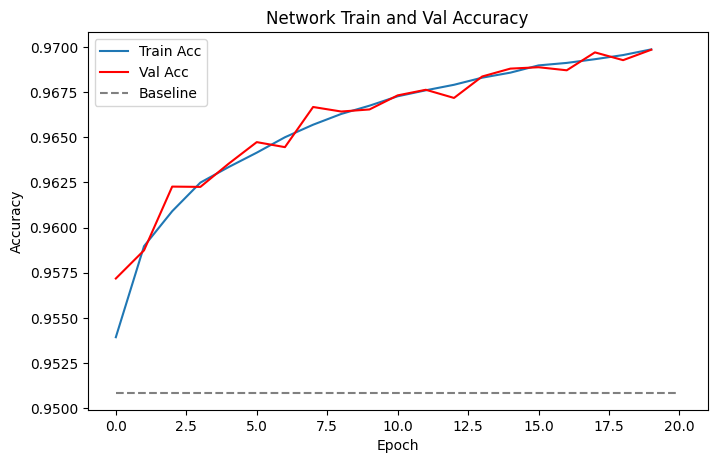

In [27]:
train_accuracy = model.history.history['accuracy']
test_accuracy = model.history.history['val_accuracy']
plt.figure(figsize=(8,5), dpi=100, facecolor=(1,1,1))
plt.plot(train_accuracy, label='Train Acc')
plt.plot(test_accuracy, c='r', label='Val Acc')
percent_negative = (sum(y_train == 0.0) / len(y_train))[1]
plt.plot([0, epochs], [percent_negative, percent_negative], '--', c='gray', label='Baseline')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Network Train and Val Accuracy')
plt.show()

In [29]:
threshold = 0.6
print("Test Set Metrics:")
print(classification_report(y_test[:,1], model.predict(x_test)[:,1] > threshold, 
                            target_names=['No TPA', 'TPA']))

print("\nHoldout Positive Set Metrics:")
print(classification_report(y_holdout[:,1], model.predict(x_holdout)[:,1] > threshold, 
                            target_names=['No TPA', 'TPA']))

Test Set Metrics:
              precision    recall  f1-score   support

      No TPA       0.97      1.00      0.98    174357
         TPA       0.84      0.48      0.61      9259

    accuracy                           0.97    183616
   macro avg       0.91      0.74      0.80    183616
weighted avg       0.97      0.97      0.96    183616


Holdout Positive Set Metrics:
              precision    recall  f1-score   support

      No TPA       0.00      0.00      0.00         0
         TPA       1.00      0.39      0.56      3167

    accuracy                           0.39      3167
   macro avg       0.50      0.19      0.28      3167
weighted avg       1.00      0.39      0.56      3167



In [30]:
model_name = 'pipeline_validation_model_3-15-21.h5'
model.save('../models/' + model_name)

## Visualize Network Predictions

In [44]:
def make_predictions(model_path, data, site_name, threshold):
    test_image = data
    model = keras.models.load_model(model_path)

    rgb_stack = []
    preds_stack = []
    threshold_stack = []
    print("Making Predictions")
    for month in list(test_image.keys()):
        test_pixel_vectors, width, height = get_pixel_vectors(test_image, month)
        if width > 0:
            test_pixel_vectors = normalize(test_pixel_vectors)

            r = np.reshape(np.array(test_pixel_vectors)[:,3], (width, height))
            g = np.reshape(np.array(test_pixel_vectors)[:,2], (width, height))
            b = np.reshape(np.array(test_pixel_vectors)[:,1], (width, height))
            rgb = np.stack((r,g,b), axis=-1)
            rgb_stack.append(rgb)

            preds = model.predict(np.expand_dims(test_pixel_vectors, axis=-1))
            preds_img = np.reshape(preds, (width, height, 2))[:,:,1]
            preds_stack.append(preds_img)

            thresh_img = np.clip(preds_img, threshold, 1)
            threshold_stack.append(thresh_img)
            
    rgb_median = np.median(rgb_stack, axis=0)
    preds_median = np.median(preds_stack, axis=0)
    threshold_median = np.median(threshold_stack, axis=0)

    plt.figure(dpi=150, facecolor=(1,1,1), figsize=(15,5))

    plt.subplot(1,3,1)
    
    adjusted_image = stretch_histogram(rgb_median)
    plt.imshow(adjusted_image)
    plt.title(f'{site_name} Median', size=8)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(preds_median, vmin=0, vmax=1, cmap='seismic')
    plt.title('Classification Median', size=8)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(threshold_median, cmap='gray')
    plt.title(f"Positive Pixels Median: Threshold {threshold}", size=8)
    plt.axis('off')

    title = f"{site_name} - Median Values - Neural Network Classification - Threshold {threshold}"
    plt.suptitle(title, y=1.01)
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, title + '.png'), bbox_inches='tight')
    plt.show()
    
    return rgb_stack, preds_stack, threshold_stack

### Download a test patch

In [ ]:
rect_width = 0.008
coords = [115.16987454393899, -8.091076190191433]
num_months = 6
start_date = '2020-01-01'
name = 'TPA Bengkala'
patch_history = get_history([coords], 
                            [name], 
                            rect_width,
                            num_months=num_months,
                            start_date=start_date,
                            cloud_mask=True)

### Show composite predictions

Making Predictions


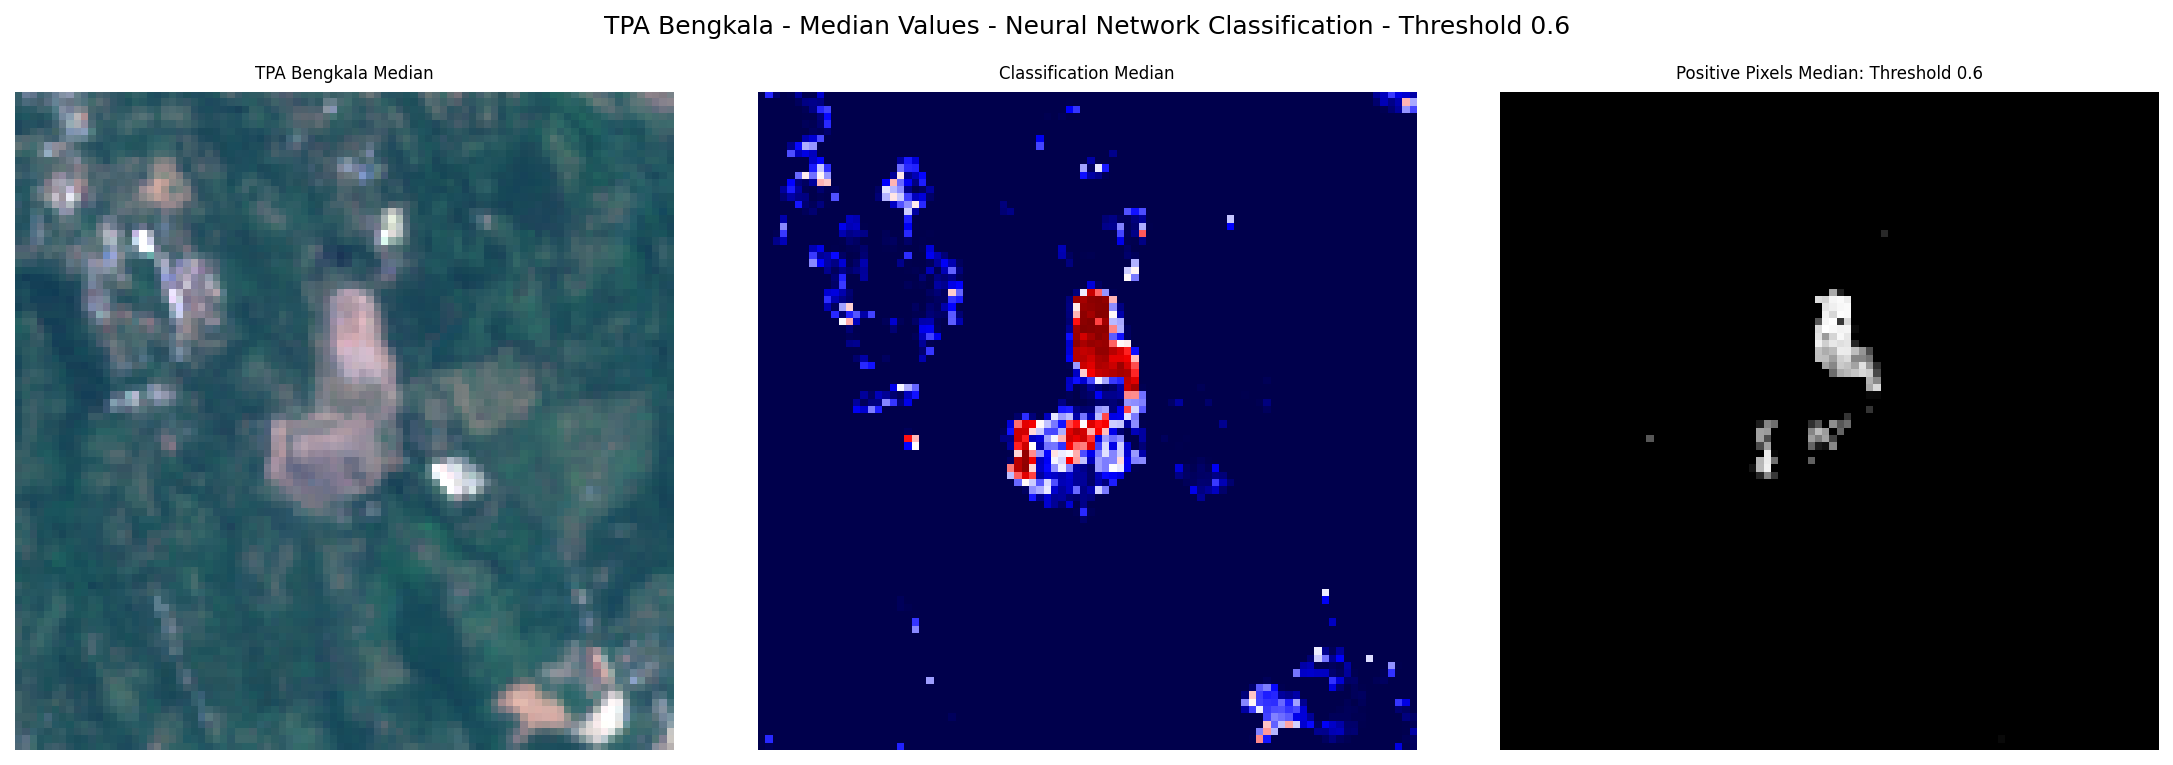

In [70]:
threshold = 0.6
model_path = '../models/pipeline_validation_model_3-15-21.h5'
rgb_stack, pred_stack, threshold_stack = make_predictions(model_path, patch_history, name, threshold)

### Show timeseries predictions

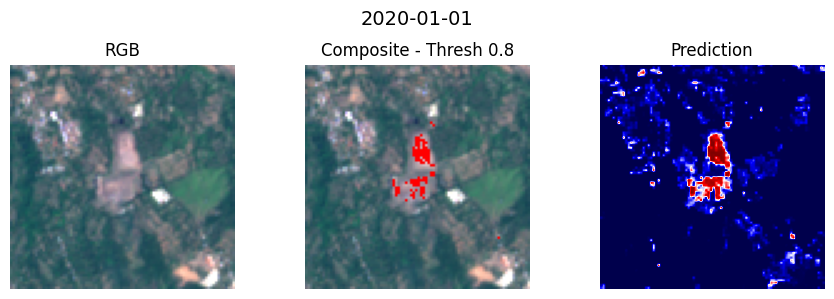

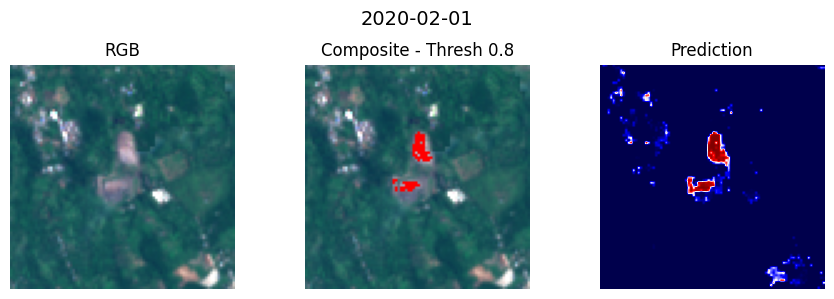

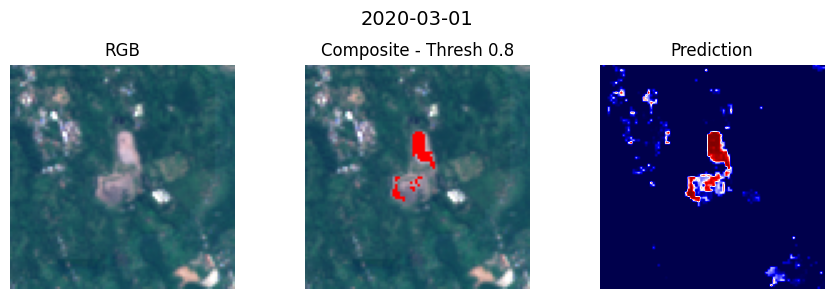

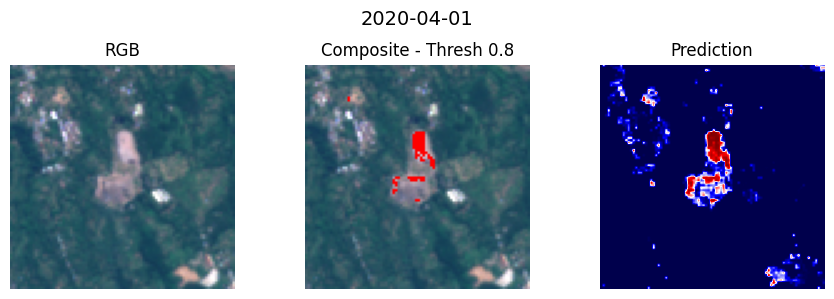

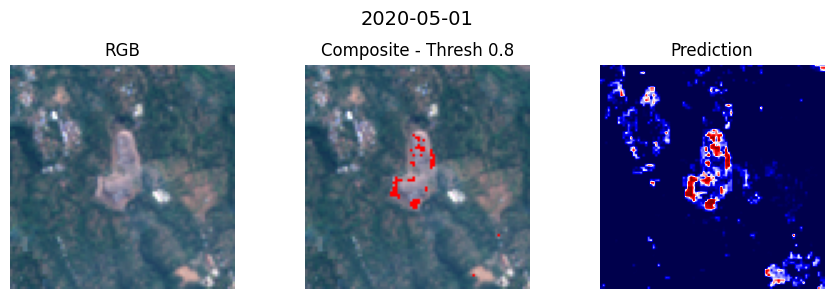

In [89]:
threshold = 0.8

for image, pred, date in zip(rgb_stack, pred_stack, list(patch_history.keys())):
    plt.figure(figsize=(9,3), facecolor=(1,1,1), dpi=100)
    plt.subplot(1,3,1)
    plt.imshow(np.clip(stretch_histogram(image), 0, 1))
    plt.axis('off')
    plt.title('RGB')
    
    plt.subplot(1,3,2)
    combo = stretch_histogram(np.copy(image))
    combo[:,:,0][np.ma.masked_greater(pred, threshold).mask] = 1
    combo[:,:,1][np.ma.masked_greater(pred, threshold).mask] = 0
    combo[:,:,2][np.ma.masked_greater(pred, threshold).mask] = 0
    plt.imshow(combo)
    plt.axis('off')
    plt.title(f'Composite - Thresh {threshold}')
    
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='seismic')
    plt.title('Prediction')
    plt.axis('off')
    
    plt.suptitle(date, size=14)
    plt.tight_layout()
    plt.show()